Loading data...
Train: 6,940,000 rows | Test: 365,000 rows

Training XGBoost Baseline...
Training time: 13.63s

Train - MAE: 4.58 | RMSE: 19.18 | R²: 0.9851
Test  - MAE: 4.41 | RMSE: 17.38 | R²: 0.9878

Training XGBoost Tuned...
Training time: 31.77s

Train - MAE: 3.12 | RMSE: 14.70 | R²: 0.9913
Test  - MAE: 2.99 | RMSE: 13.28 | R²: 0.9929

Training LightGBM...
Training time: 10.38s

Train - MAE: 4.63 | RMSE: 19.08 | R²: 0.9853
Test  - MAE: 4.47 | RMSE: 17.41 | R²: 0.9877

Training Random Forest...
Training time: 719.76s

Train - MAE: 4.63 | RMSE: 23.37 | R²: 0.9779
Test  - MAE: 4.56 | RMSE: 22.66 | R²: 0.9792

MODEL COMPARISON (sorted by Test R²)
           model  test_mae  test_rmse  test_r2  train_time
   XGBoost Tuned  2.986643  13.284686 0.992864   31.774735
XGBoost Baseline  4.413389  17.384518 0.987779   13.626217
        LightGBM  4.471194  17.412754 0.987740   10.378924
   Random Forest  4.557120  22.664121 0.979230  719.764003


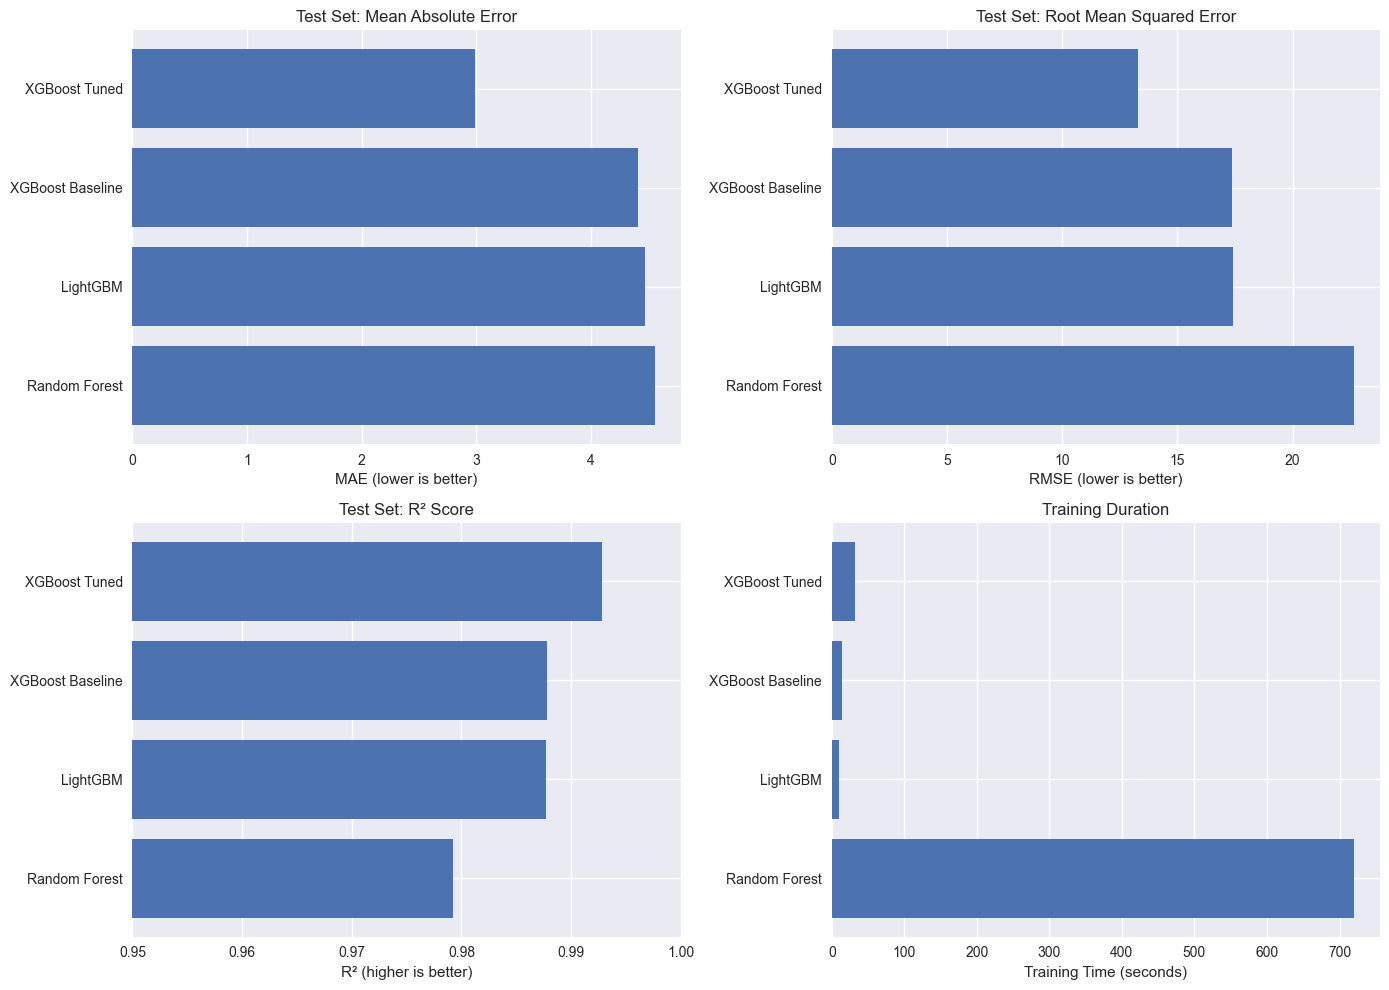


BEST MODEL: XGBoost Tuned
Test R²: 0.9929

Model comparison saved to: ../Shared project assets/data/processed/model_comparison.csv

✅ MODEL COMPARISON COMPLETE!


In [2]:
# ========================================
# MODEL COMPARISON & HYPERPARAMETER TUNING
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import time

plt.style.use('seaborn-v0_8')

# ========================================
# 1. LOAD PREPARED DATA
# ========================================

print("Loading data...")
df = pd.read_csv(r"..\Shared project assets\data\raw\datasets\daily_timeseries.csv")
df['date'] = pd.to_datetime(df['date'])

# Prepare features (same as baseline)
target = 'actual_demand'
exclude_cols = [
    'date', 'actual_demand', 'expected_demand', 'unfulfilled_demand',
    'sku_id', 'location_id', 'sku_name', 'city', 'brand',
    'category', 'segment', 'pack_size', 'material', 'life_category',
    'abc_class', 'region', 'location_type', 'distribution_tier',
    'channel', 'month'
]

all_cols = [col for col in df.columns if col not in exclude_cols]
feature_cols = df[all_cols].select_dtypes(include=['number']).columns.tolist()

# Fill missing values
df[feature_cols] = df[feature_cols].fillna(0)
df[target] = df[target].fillna(0)

# Train/test split
train_mask = df['date'] < '2023-01-01'
X_train = df.loc[train_mask, feature_cols]
y_train = df.loc[train_mask, target]
X_test = df.loc[~train_mask, feature_cols]
y_test = df.loc[~train_mask, target]

print(f"Train: {len(X_train):,} rows | Test: {len(X_test):,} rows")

# ========================================
# 2. DEFINE EVALUATION FUNCTION
# ========================================

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Train and evaluate a model"""
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print('='*60)
    
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    # Predictions
    y_train_pred = np.maximum(model.predict(X_train), 0)
    y_test_pred = np.maximum(model.predict(X_test), 0)
    
    # Metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"Training time: {train_time:.2f}s")
    print(f"\nTrain - MAE: {train_mae:.2f} | RMSE: {train_rmse:.2f} | R²: {train_r2:.4f}")
    print(f"Test  - MAE: {test_mae:.2f} | RMSE: {test_rmse:.2f} | R²: {test_r2:.4f}")
    
    return {
        'model': name,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'train_time': train_time,
        'predictions': y_test_pred
    }

# ========================================
# 3. TRAIN MULTIPLE MODELS
# ========================================

results = []

# Model 1: XGBoost Baseline (from before)
xgb_baseline = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
results.append(evaluate_model('XGBoost Baseline', xgb_baseline, X_train, y_train, X_test, y_test))

# Model 2: XGBoost Tuned (more trees, deeper)
xgb_tuned = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
results.append(evaluate_model('XGBoost Tuned', xgb_tuned, X_train, y_train, X_test, y_test))

# Model 3: LightGBM (faster alternative)
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
results.append(evaluate_model('LightGBM', lgb_model, X_train, y_train, X_test, y_test))

# Model 4: Random Forest (baseline tree ensemble)
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
results.append(evaluate_model('Random Forest', rf_model, X_train, y_train, X_test, y_test))

# ========================================
# 4. COMPARE RESULTS
# ========================================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_r2', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON (sorted by Test R²)")
print("="*60)
print(results_df[['model', 'test_mae', 'test_rmse', 'test_r2', 'train_time']].to_string(index=False))

# ========================================
# 5. VISUALIZE COMPARISON
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Test MAE
axes[0, 0].barh(results_df['model'], results_df['test_mae'])
axes[0, 0].set_xlabel('MAE (lower is better)')
axes[0, 0].set_title('Test Set: Mean Absolute Error')
axes[0, 0].invert_yaxis()

# Test RMSE
axes[0, 1].barh(results_df['model'], results_df['test_rmse'])
axes[0, 1].set_xlabel('RMSE (lower is better)')
axes[0, 1].set_title('Test Set: Root Mean Squared Error')
axes[0, 1].invert_yaxis()

# Test R²
axes[1, 0].barh(results_df['model'], results_df['test_r2'])
axes[1, 0].set_xlabel('R² (higher is better)')
axes[1, 0].set_title('Test Set: R² Score')
axes[1, 0].set_xlim([0.95, 1.0])
axes[1, 0].invert_yaxis()

# Training Time
axes[1, 1].barh(results_df['model'], results_df['train_time'])
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_title('Training Duration')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# ========================================
# 6. SAVE BEST MODEL
# ========================================

best_model_name = results_df.iloc[0]['model']
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test R²: {results_df.iloc[0]['test_r2']:.4f}")
print('='*60)

# Save comparison results
results_df.to_csv(
    r"..\Shared project assets\data\processed\model_comparison.csv",
    index=False
)
print("\nModel comparison saved to: ../Shared project assets/data/processed/model_comparison.csv")

print("\n✅ MODEL COMPARISON COMPLETE!")
